# Setup

In [1]:
import torch
from torch import einsum
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from clasp import CLASP, Transformer, tokenize, basic_rand_sampler, basic_aa_tokenizer, CLASPDataset
from functools import partial
from collections import OrderedDict
import requests
import matplotlib.pyplot as plt

# Instantiate model

In [2]:
text_enc = Transformer(
    num_tokens = 49408,
    dim = 768,
    depth = 12,
    seq_len = 1024,
    reversible=True
)

bioseq_enc = Transformer(
    num_tokens = 23,
    dim = 768,
    depth = 12,
    seq_len = 512,
    sparse_attn = False,
    reversible=True
)

model = CLASP(
    text_encoder = text_enc,
    bioseq_encoder = bioseq_enc
)

Download the weights from Google Drive via https://drive.google.com/file/d/1f7Glzw6RthozU3vH1i18xhuXa5FIYl77/view?usp=sharing and update the path to the weights if necessary.

In [3]:
path_weights = "run48_2021-07-18_13_31_19_step00005000.pt"

In [4]:
ckpt = torch.load(path_weights, map_location="cpu")

In [5]:
model.load_state_dict(ckpt)

<All keys matched successfully>

In [6]:
model.eval();

In [7]:
# if you wanto to run it on GPU
#device = torch.device("cuda:0")
#model.to(device)

# Tokenizer setup

In [8]:
text_sampler = partial(basic_rand_sampler, sample_len=1024)
text_tok = partial(tokenize, context_length=1024, return_mask=True)

bioseq_sampler = partial(basic_rand_sampler, sample_len=512)
bioseq_tok = partial(basic_aa_tokenizer, context_length=512, return_mask=True)

# Data setup single example

## Text

In [9]:
text_orig = "protein that is present in the blood"
text, text_mask = text_tok(text_orig)
text, text_mask

(tensor([[8088,  682,  533,  ...,    0,    0,    0]]),
 tensor([[ True,  True,  True,  ..., False, False, False]]))

In [10]:
model.text_encoder(text, mask=text_mask).shape

torch.Size([1, 768])

## Bioseq

In [11]:
bioseq_orig = "BBCDEFGHI"
bioseq, bioseq_mask = bioseq_tok(bioseq_orig)
bioseq, bioseq_mask

(tensor([22, 22,  1,  2,  3,  4,  5,  6,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,

# Query example

## Bioseq

Proteins related to query "blood":
1. **Small integral membrane protein 1** (https://www.uniprot.org/uniprot/B2RUZ4): Regulator of red blood cell formation.
1. **Histo-blood group ABO system transferase** (https://www.uniprot.org/uniprot/P38649): This protein is involved in the pathway protein glycosylation.

Proteins related to query "brain":
1. **Tachykinins** (https://www.uniprot.org/uniprot/Q9VGE8): Tachykinins are active peptides which excite neurons. smooth muscles.
1. **T-box brain protein 1** (https://www.uniprot.org/uniprot/Q16650): Transcriptional repressor involved in multiple aspects of cortical development.

Proteins related to query "t-cell":
1. **T-cell surface glycoprotein CD3 zeta chain** (https://www.uniprot.org/uniprot/P20963): Part of the TCR-CD3 complex present on T-lymphocyte cell surface that plays an essential role in adaptive immune response. 
1. **Interleukin-2** (https://www.uniprot.org/uniprot/P60568): Produced by T-cells in response to antigenic or mitogenic stimulation.

Proteins related to query "hormones":
1. **Glycoprotein hormones alpha chain** (https://www.uniprot.org/uniprot/P01215): Shared alpha chain of the active heterodimeric glycoprotein hormones.
1. **Crustacean hyperglycemic hormones 3** (https://www.uniprot.org/uniprot/O97385): Hormone found in the sinus gland of isopods and decapods which controls the blood sugar level.

Proteins related to query "virus":
1. **mRNA-capping enzyme catalytic subunit** (https://www.uniprot.org/uniprot/P04298): The heterodimeric enzyme is also involved in early viral gene transcription termination and intermediate viral gene transcription initiation.
1. **Hepatitis A virus cellular receptor 2** (https://www.uniprot.org/uniprot/Q8TDQ0): Cell surface receptor implicated in modulating innate and adaptive immune responses.

Proteins related to query "IgG":
1. **IgG kappa variable 1-17** (https://www.uniprot.org/uniprot/P01599): V region of the variable domain of immunoglobulin light chains that participates in the antigen recognition.
1. **IgG lambda variable 1-47** (https://www.uniprot.org/uniprot/P01700): V region of the variable domain of immunoglobulin light chains that participates in the antigen recognition.

In [12]:
prot_urls = ["https://www.uniprot.org/uniprot/B2RUZ4.fasta",
             "https://www.uniprot.org/uniprot/P38649.fasta",
             
             "https://www.uniprot.org/uniprot/Q9VGE8.fasta",
             "https://www.uniprot.org/uniprot/Q16650.fasta",
             
             "https://www.uniprot.org/uniprot/P20963.fasta",
             "https://www.uniprot.org/uniprot/P60568.fasta",
             
             "https://www.uniprot.org/uniprot/P01215.fasta",
             "https://www.uniprot.org/uniprot/O97385.fasta",
             
             "https://www.uniprot.org/uniprot/P04298.fasta",
             "https://www.uniprot.org/uniprot/Q8TDQ0.fasta",
            
             "https://www.uniprot.org/uniprot/P01599.fasta",
             "https://www.uniprot.org/uniprot/P01700.fasta"]

In [13]:
bioseq_orig =["".join(requests.get(url).text.split("\n")[1:]) for url in prot_urls]

In [14]:
len(bioseq_orig)

12

In [15]:
bioseq_orig

['MQPQESHVHYSRWEDGSRDGVSLGAVSSTEEASRCRRISQRLCTGKLGIAMKVLGGVALFWIIFILGYLTGYYVHKCK',
 'MNLRGRPKCNFLHLGILPFAVFVLVFFGYLFLSFRSQNLGHPGAVTRNAYLQPRVLKPTRKDVLVLTPWLAPIIWEGTFNIDILNEQFRIRNTTIGLTVFAIKKYVVFLKLFLETAEQHFMVGHKVIYYVFTDRPADVPQVILGAGRQLVVLTVRNYTRWQDVSMHRMEMISHFSERRFLREVDYLVCADADMKFSDHVGVEILSTFFGTLHPGFYSSSREAFTYERRPQSQAYIPWDRGDFYYGGAFFGGSVLEVYHLTKACHEAMMEDKANGIEPVWHDESYLNKYLLYHKPTKVLSPEYLWDQQLLGWPSIMKKLRYVAVPKDHQAIRN',
 'MRPLSGLIALALLLLLLLTAPSSAADTETESSGSPLTPGAEEPRRVVKRAPTSSFIGMRGKKDEEHDTSEGNWLGSGPDPLDYADEEADSSYAENGRRLKKAPLAFVGLRGKKFIPINNRLSDVLQSLEEERLRDSLLQDFFDRVAGRDGSAVGKRAPTGFTGMRGKRPALLAGDDDAEADEATELQQKRAPVNSFVGMRGKKDVSHQHYKRAALSDSYDLRGKQQRFADFNSKFVAVRGKKSDLEGNGVGIGDDHEQALVHPWLYLWGEKRAPNGFLGMRGKRPALFE',
 'MQLEHCLSPSIMLSKKFLNVSSSYPHSGGSELVLHDHPIISTTDNLERSSPLKKITRGMTNQSDTDNFPDSKDSPGDVQRSKLSPVLDGVSELRHSFDGSAADRYLLSQSSQPQSAATAPSAMFPYPGQHGPAHPAFSIGSPSRYMAHHPVITNGAYNSLLSNSSPQGYPTAGYPYPQQYGHSYQGAPFYQFSSTQPGLVPGKAQVYLCNRPLWLKFHRHQTEMIITKQGRRMFPFLSFNISGLDPTAHYNIFVDVILADPNHWRFQGGKWVPCGKADTNVQGN

In [16]:
[len(s) for s in bioseq_orig]

[78, 332, 289, 682, 164, 153, 116, 102, 844, 301, 117, 117]

In [17]:
bioseq_ = [bioseq_tok(bioseq_sampler(s)) for s in bioseq_orig]

In [18]:
bioseq, bioseq_mask = list(zip(*bioseq_))
bioseq      = torch.cat([s.unsqueeze(0) for s in bioseq])
bioseq_mask = torch.cat([s.unsqueeze(0) for s in bioseq_mask])
bioseq, bioseq_mask

(tensor([[10, 14, 13,  ...,  0,  0,  0],
         [10, 11,  9,  ...,  0,  0,  0],
         [10, 15, 13,  ...,  0,  0,  0],
         ...,
         [10,  4, 16,  ...,  0,  0,  0],
         [10,  2, 10,  ...,  0,  0,  0],
         [10,  0,  5,  ...,  0,  0,  0]]),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]))

In [19]:
bioseq.shape, bioseq_mask.shape

(torch.Size([12, 512]), torch.Size([12, 512]))

In [20]:
bioseq_out = model.bioseq_encoder(bioseq, mask=bioseq_mask)
bioseq_out.shape

torch.Size([12, 768])

## Text

Change here the text query:

In [21]:
#text_orig = "protein that is present in the blood"
#text_orig = "blood cells blood stream nutrition"
#text_orig = "brain neurology nerve cells"
#text_orig = "proteins that play a role in the blood transport"
text_orig = "hormone regulation and similar functions"
#text_orig = "immune system and antigen processing"
#text_orig = "viral infection and replication"
#text_orig = "antibody immune reaction"

In [22]:
text, text_mask = text_tok(text_orig)
text, text_mask

(tensor([[31283, 14267,   537,  ...,     0,     0,     0]]),
 tensor([[ True,  True,  True,  ..., False, False, False]]))

In [23]:
text_out = model.text_encoder(text, mask=text_mask)
text_out.shape

torch.Size([1, 768])

## Similarity

In [24]:
text_out_norm = F.normalize(text_out, p=2, dim =-1)
bioseq_out_norm = F.normalize(bioseq_out, p=2, dim =-1)

In [25]:
sim = einsum('n d, n d -> n', text_out_norm, bioseq_out_norm)
sim.tolist()

[0.19082853198051453,
 0.1475561261177063,
 0.1467944234609604,
 0.16863828897476196,
 0.1605483740568161,
 0.15268614888191223,
 0.201420858502388,
 0.16629259288311005,
 0.15658608078956604,
 0.171107679605484,
 0.16047260165214539,
 0.15689802169799805]

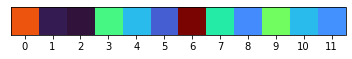

In [26]:
plt.imshow(sim.data.unsqueeze(0).numpy(), cmap="turbo");
plt.gca().set_xticks(range(len(sim)));
plt.gca().set_yticks([]);

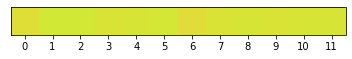

In [27]:
# colors normalized to the cosine similarity ranges -1 and 1
plt.imshow(sim.data.unsqueeze(0).numpy(), cmap="turbo", vmin=-1., vmax=1.);
plt.gca().set_xticks(range(len(sim)));
plt.gca().set_yticks([]);

# Citric acid cycle

The [citric acid cycle](https://en.wikipedia.org/wiki/Citric_acid_cycle) is a very import chain of reactions in cells and we use the sequences of some of the [involved enzymes](https://en.wikipedia.org/wiki/Citric_acid_cycle#Steps) to look for interesting relationships in the high-dimensional embedding space.

1. Citrate synthase, https://www.uniprot.org/uniprot/O75390
1. Cytoplasmic aconitate hydratase, https://www.uniprot.org/uniprot/P21399
1. Isocitrate dehydrogenase NADP cytoplasmic, https://www.uniprot.org/uniprot/O75874
1. Fumarate hydratase mitochondrial, https://www.uniprot.org/uniprot/P07954
1. Malate dehydrogenase cytoplasmic, https://www.uniprot.org/uniprot/P40925

In [28]:
cca_urls = ["https://www.uniprot.org/uniprot/O75390.fasta",
            "https://www.uniprot.org/uniprot/P21399.fasta",
            "https://www.uniprot.org/uniprot/O75874.fasta",
            "https://www.uniprot.org/uniprot/P07954.fasta",
            "https://www.uniprot.org/uniprot/P40925.fasta"]

In [29]:
# we also add the proteins from above to see if the cca proteins are clustered together
cca_seq =["".join(requests.get(url).text.split("\n")[1:]) for url in cca_urls+prot_urls]

In [30]:
#cca_seq

In [31]:
[len(s) for s in cca_seq]

[466,
 889,
 414,
 510,
 334,
 78,
 332,
 289,
 682,
 164,
 153,
 116,
 102,
 844,
 301,
 117,
 117]

In [32]:
bioseq_ = [bioseq_tok(bioseq_sampler(s)) for s in cca_seq]

In [33]:
bioseq, bioseq_mask = list(zip(*bioseq_))
bioseq      = torch.cat([s.unsqueeze(0) for s in bioseq])
bioseq_mask = torch.cat([s.unsqueeze(0) for s in bioseq_mask])
bioseq, bioseq_mask

(tensor([[10,  0,  9,  ...,  0,  0,  0],
         [16,  7, 17,  ...,  2,  0,  9],
         [10, 16,  8,  ...,  0,  0,  0],
         ...,
         [10,  4, 16,  ...,  0,  0,  0],
         [10,  2, 10,  ...,  0,  0,  0],
         [10,  0,  5,  ...,  0,  0,  0]]),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]))

In [34]:
bioseq.shape, bioseq_mask.shape

(torch.Size([17, 512]), torch.Size([17, 512]))

In [35]:
bioseq_out = model.bioseq_encoder(bioseq, mask=bioseq_mask)
bioseq_out.shape

torch.Size([17, 768])

In [36]:
u, s, v = torch.svd(bioseq_out)

In [37]:
#u, s, v
s

tensor([60.6079, 31.5279, 29.5089, 26.8505, 25.9734, 25.2728, 22.3653, 21.6026,
        20.5407, 19.5273, 17.3956, 16.9678, 15.8024, 15.2223, 13.8886, 12.8866,
         6.9062], grad_fn=<SvdHelperBackward>)

In [38]:
u.shape, s.shape, v.shape

(torch.Size([17, 17]), torch.Size([17]), torch.Size([768, 17]))

In [39]:
bioseq_out.shape, v.t()[0].unsqueeze(0).shape

(torch.Size([17, 768]), torch.Size([1, 768]))

In [40]:
# project on the top-2 eigenvectors
x_coords = einsum("id, jd -> ij", bioseq_out, v.t()[0].unsqueeze(0)).data
y_coords = einsum("id, jd -> ij", bioseq_out, v.t()[1].unsqueeze(0)).data

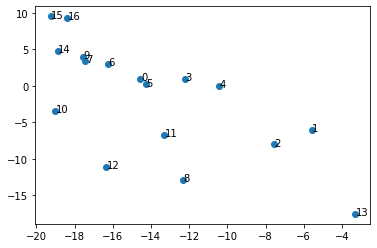

In [41]:
plt.scatter(x_coords, y_coords);
for i, txt in enumerate(x_coords):
    plt.annotate(i, (x_coords[i]+0.025, y_coords[i]-0.2))

# Glycolysis

[Glycolysis](https://en.wikipedia.org/wiki/Glycolysis) is the metabolic pathway that converts glucose C<sub>6</sub>H<sub>12</sub>O<sub>6</sub> into pyruvate CH<sub>3</sub>COCOO<sup>−</sup> and a hydrogen ion H<sup>+</sup>. The free energy released in this process is used to form the high-energy molecules ATP and NADH (reduced nicotinamide adenine dinucleotide).

1. Hexokinase-1 (https://www.uniprot.org/uniprot/P19367)
1. Glucose-6-phosphate isomerase (https://www.uniprot.org/uniprot/P06744)
1. ATP-dependent 6-phosphofructokinase, muscle type (https://www.uniprot.org/uniprot/P08237)
1. Fructose-bisphosphate aldolase A (https://www.uniprot.org/uniprot/P04075)
1. Triosephosphate isomerase (https://www.uniprot.org/uniprot/P60174)
1. Glyceraldehyde-3-phosphate dehydrogenase (https://www.uniprot.org/uniprot/P04406)
1. Phosphoglycerate kinase 1 (https://www.uniprot.org/uniprot/P00558)
1. Phosphoglycerate mutase 1 (https://www.uniprot.org/uniprot/P18669)
1. Alpha-enolase (https://www.uniprot.org/uniprot/P06733)
1. Pyruvate kinase PKLR (https://www.uniprot.org/uniprot/P30613)

In [42]:
glyc_urls = ["https://www.uniprot.org/uniprot/P19367.fasta",
            "https://www.uniprot.org/uniprot/P06744.fasta",
            "https://www.uniprot.org/uniprot/P08237.fasta",
            "https://www.uniprot.org/uniprot/P04075.fasta",
            "https://www.uniprot.org/uniprot/P60174.fasta",
            "https://www.uniprot.org/uniprot/P04406.fasta",
            "https://www.uniprot.org/uniprot/P00558.fasta",
            "https://www.uniprot.org/uniprot/P18669.fasta",
            "https://www.uniprot.org/uniprot/P06733.fasta",
            "https://www.uniprot.org/uniprot/P30613.fasta"]

In [43]:
# we also add the proteins from above to see if the cca proteins are clustered together
glyc_seq =["".join(requests.get(url).text.split("\n")[1:]) for url in glyc_urls]#+prot_urls]

In [44]:
#glyc_seq

In [45]:
[len(s) for s in glyc_seq]

[917, 558, 780, 364, 249, 335, 417, 254, 434, 574]

In [46]:
bioseq_ = [bioseq_tok(bioseq_sampler(s)) for s in glyc_seq]

In [47]:
bioseq, bioseq_mask = list(zip(*bioseq_))
bioseq      = torch.cat([s.unsqueeze(0) for s in bioseq])
bioseq_mask = torch.cat([s.unsqueeze(0) for s in bioseq_mask])
bioseq, bioseq_mask

(tensor([[11,  6,  3,  ..., 14, 14, 17],
         [10,  0,  0,  ...,  4,  2, 14],
         [17,  4, 15,  ..., 17, 17,  2],
         ...,
         [10,  0,  0,  ...,  0,  0,  0],
         [10, 16,  7,  ...,  0,  0,  0],
         [15,  0, 16,  ...,  2,  9, 19]]),
 tensor([[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True]]))

In [48]:
bioseq.shape, bioseq_mask.shape

(torch.Size([10, 512]), torch.Size([10, 512]))

In [49]:
bioseq_out = model.bioseq_encoder(bioseq, mask=bioseq_mask)
bioseq_out.shape

torch.Size([10, 768])

In [50]:
u, s, v = torch.svd(bioseq_out)

In [51]:
#u, s, v
s

tensor([49.9514, 30.6073, 24.9115, 22.4767, 20.5456, 19.7257, 17.5594, 17.2067,
        15.3715, 14.1553], grad_fn=<SvdHelperBackward>)

In [52]:
u.shape, s.shape, v.shape

(torch.Size([10, 10]), torch.Size([10]), torch.Size([768, 10]))

In [53]:
bioseq_out.shape, v.t()[0].unsqueeze(0).shape

(torch.Size([10, 768]), torch.Size([1, 768]))

In [54]:
# project on the top-2 eigenvectors
x_coords = einsum("id, jd -> ij", bioseq_out, v.t()[0].unsqueeze(0)).data
y_coords = einsum("id, jd -> ij", bioseq_out, v.t()[1].unsqueeze(0)).data

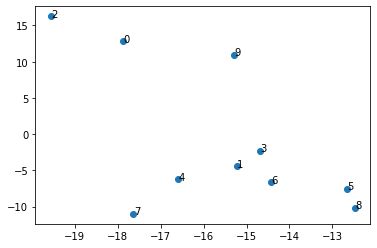

In [55]:
plt.scatter(x_coords, y_coords);
for i, txt in enumerate(x_coords):
    plt.annotate(i, (x_coords[i]+0.01, y_coords[i]-0.1))

# End